# Example notebook

In [1]:
import os
print(os.getcwd())
os.chdir('/app')
print(os.getcwd())

/
/app


In [2]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = 'data/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
# checkpoint = torch.load('model_best_val_loss_var.pkl')
checkpoint = torch.load('model_best_val_loss_var_trained2.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()
print("Model loaded.")

Model loaded.


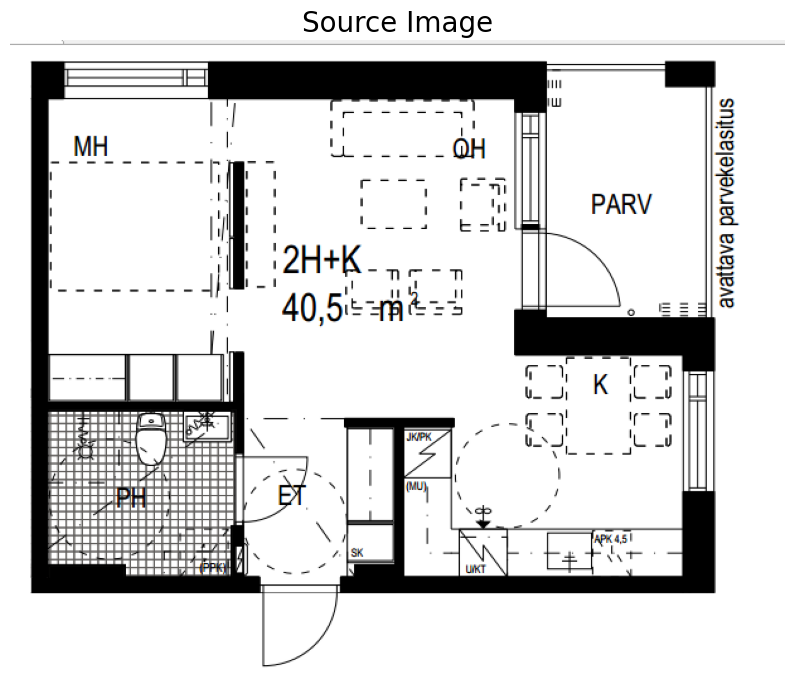

In [9]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image'].cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(10,10))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

## The SVG floorplan
If the floorplan includes two floors the other floor might not be visible, but it will be parsed never the less.

In [10]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= data_folder+folder+"model.svg", width=800)

## Parsed labels

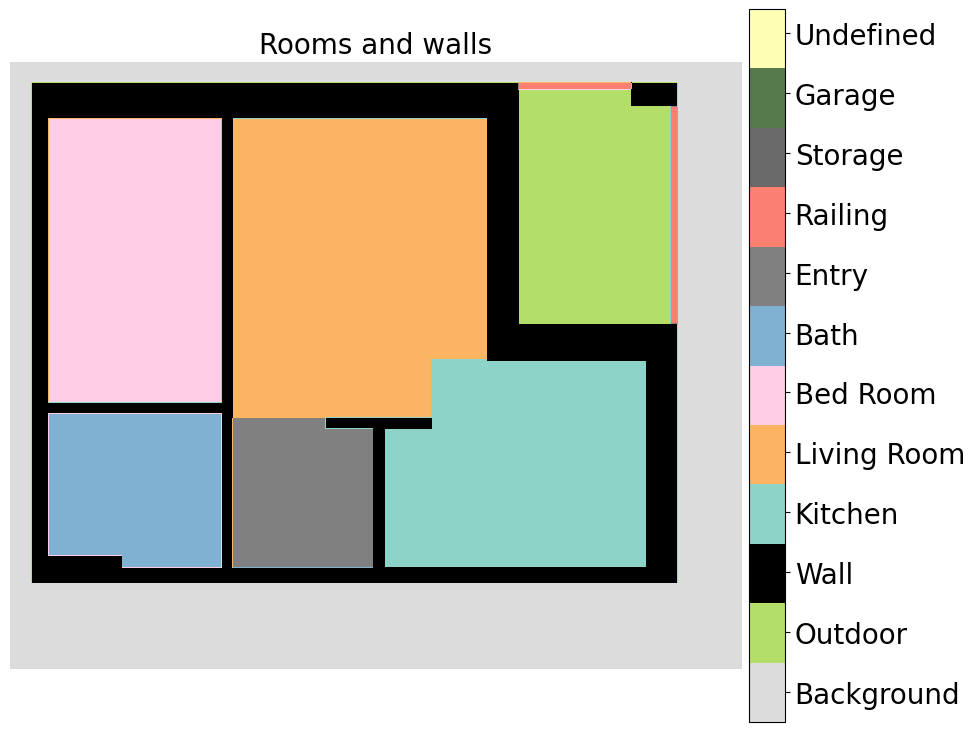

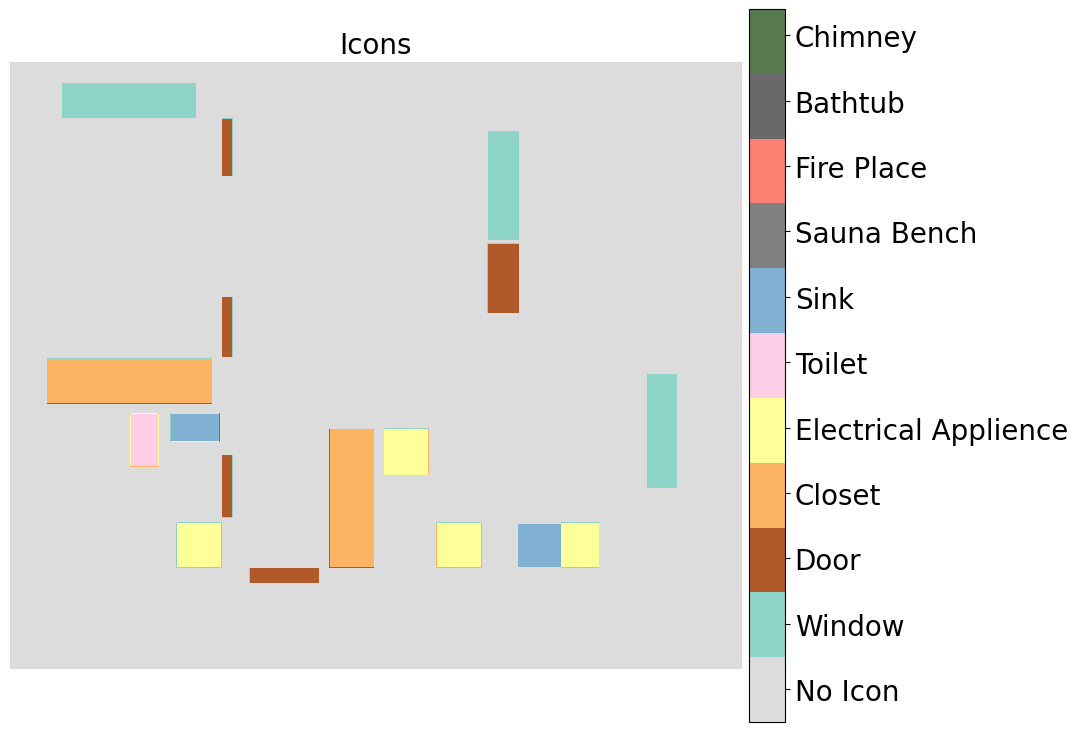

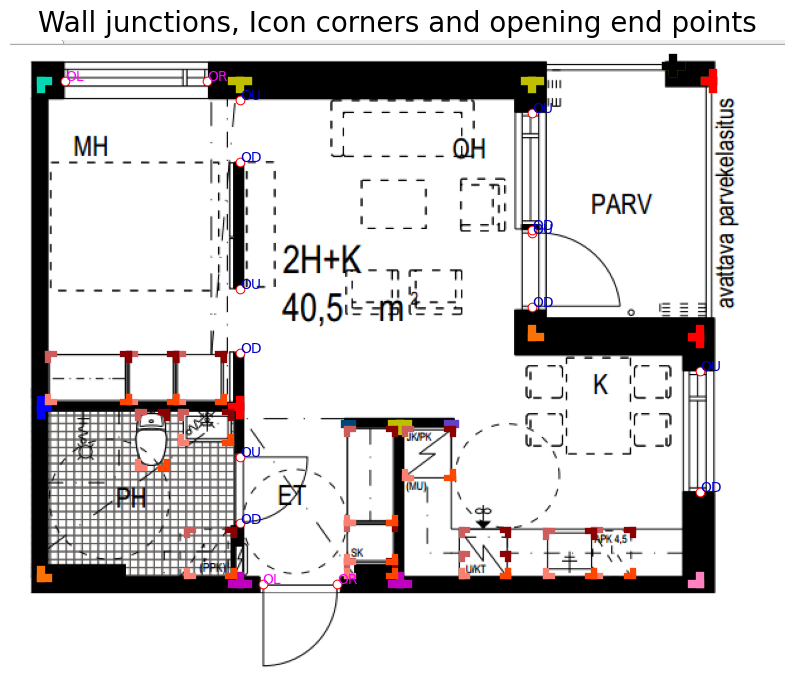

In [15]:
label_np = label.data.numpy()[0]
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
n_rooms = 12
rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
n_icons = 11
iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Wall junctions, Icon corners and opening end points', fontsize=20)
ax.axis('off')
ax.imshow(np_img)
h, w, _ = np_img.shape
draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
plt.show()

## Networks prediction for the segmentation

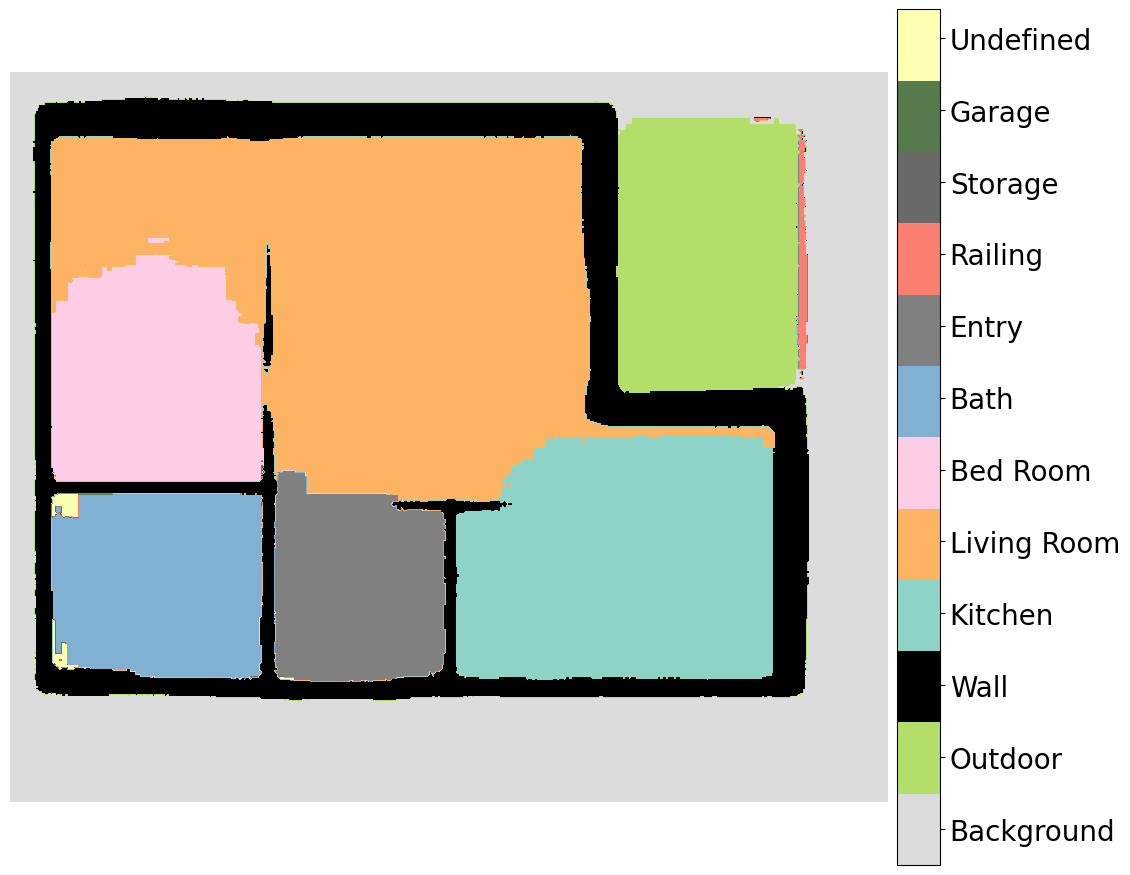

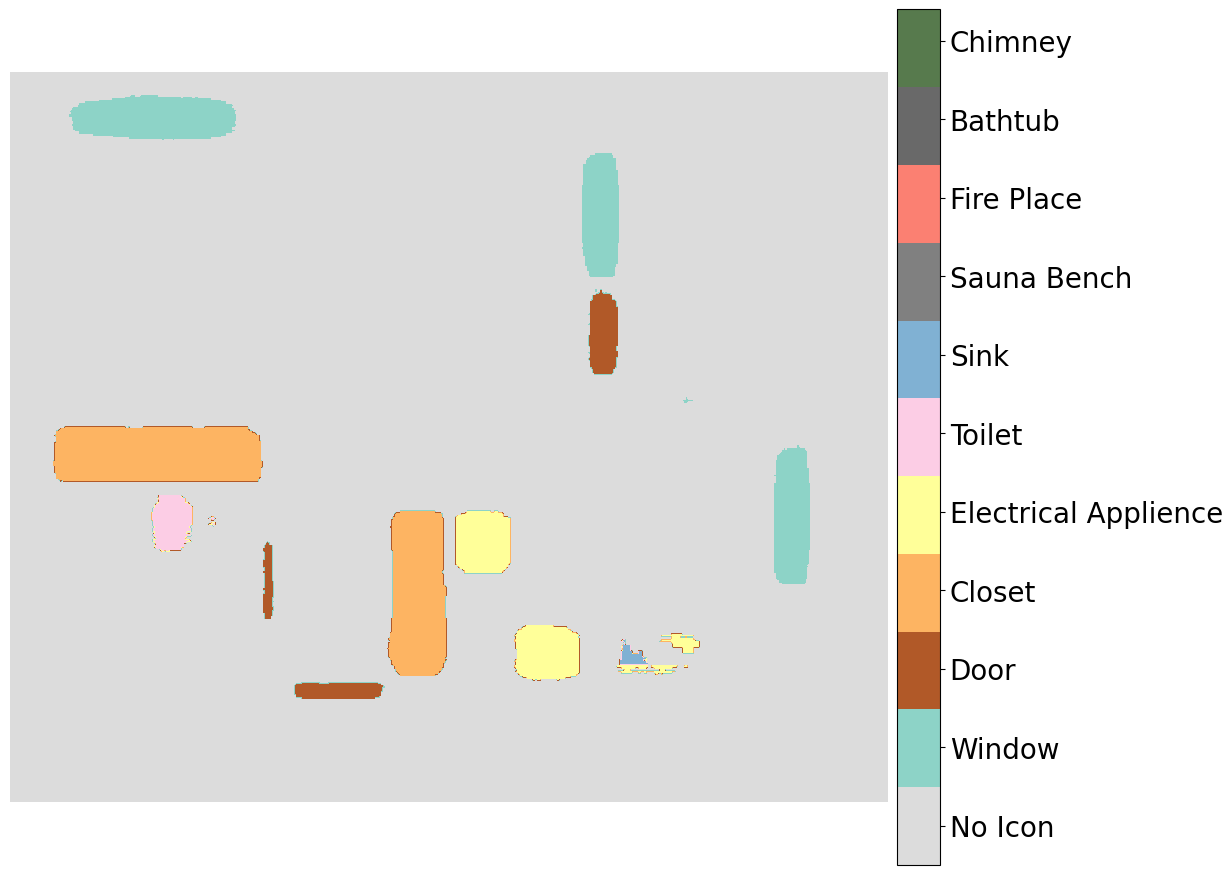

In [16]:
with torch.no_grad():
    height = label_np.shape[1]
    width = label_np.shape[2]
    img_size = (height, width)
    
    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(image, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)
rooms_label = label_np[0]
icons_label = label_np[1]

rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(rooms_pred, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(icons_pred, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

## Post-processed polygons

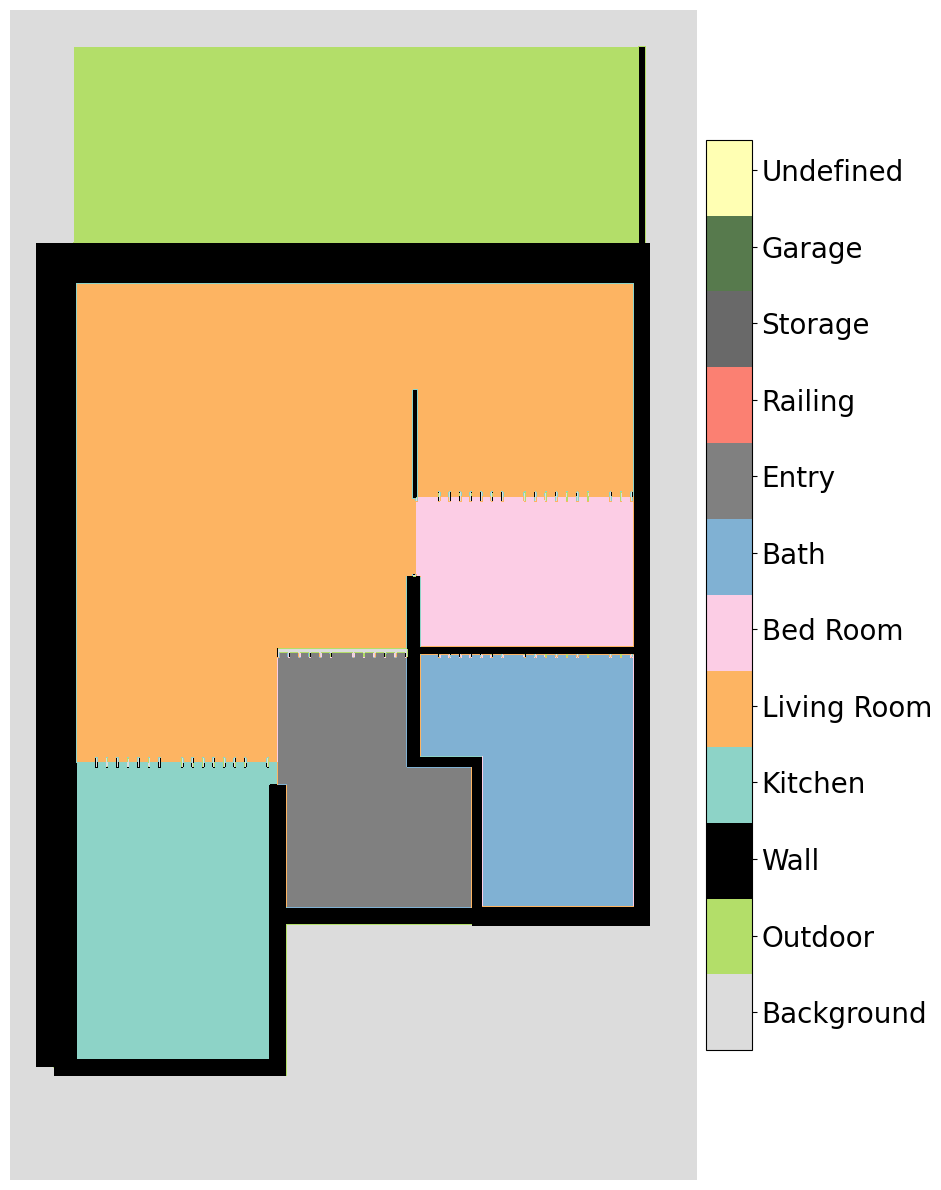

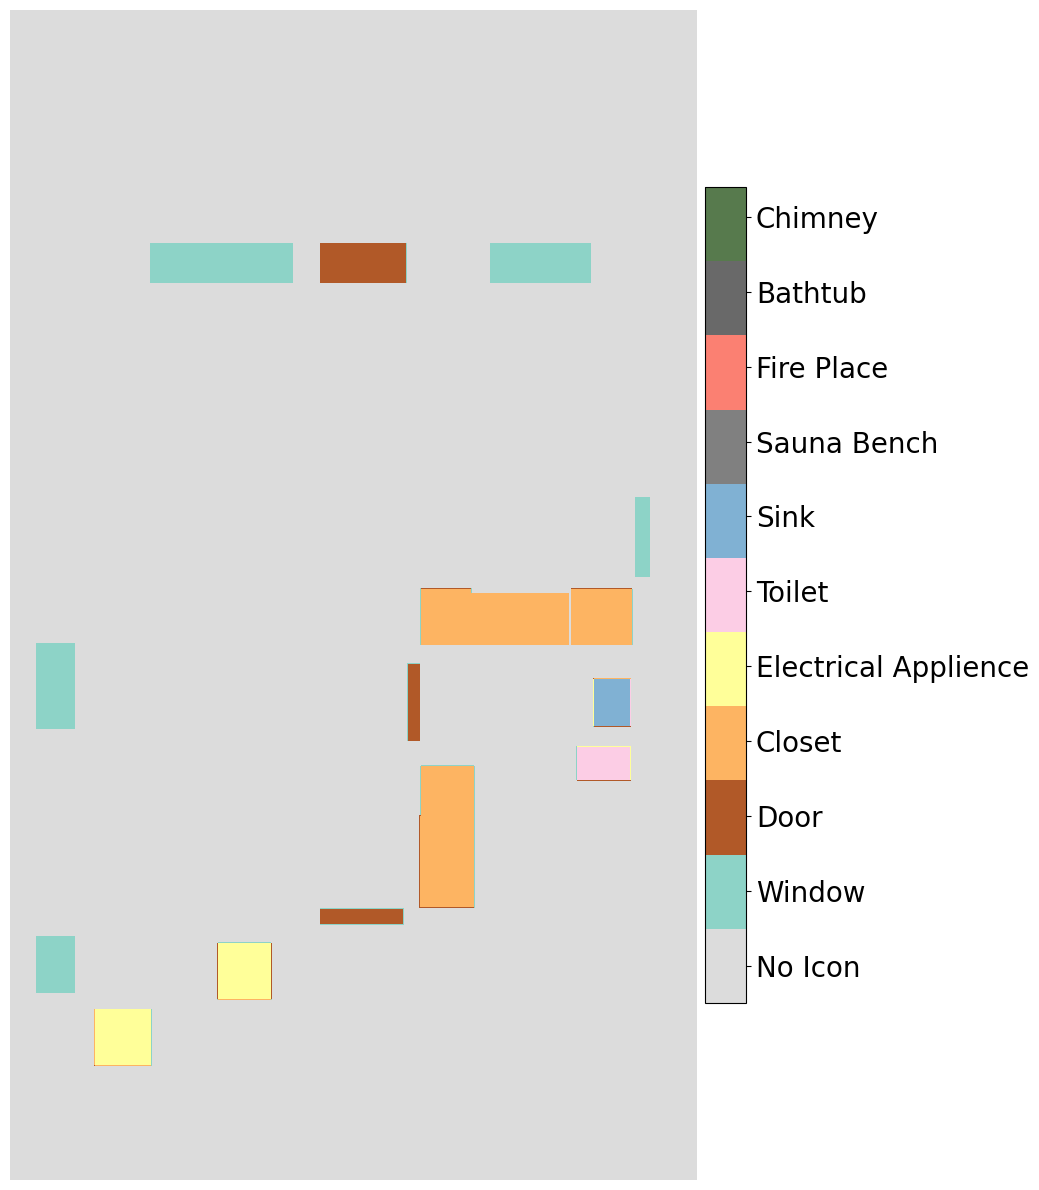

In [34]:

heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)
plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()

## Ground truth and prediction comparisons

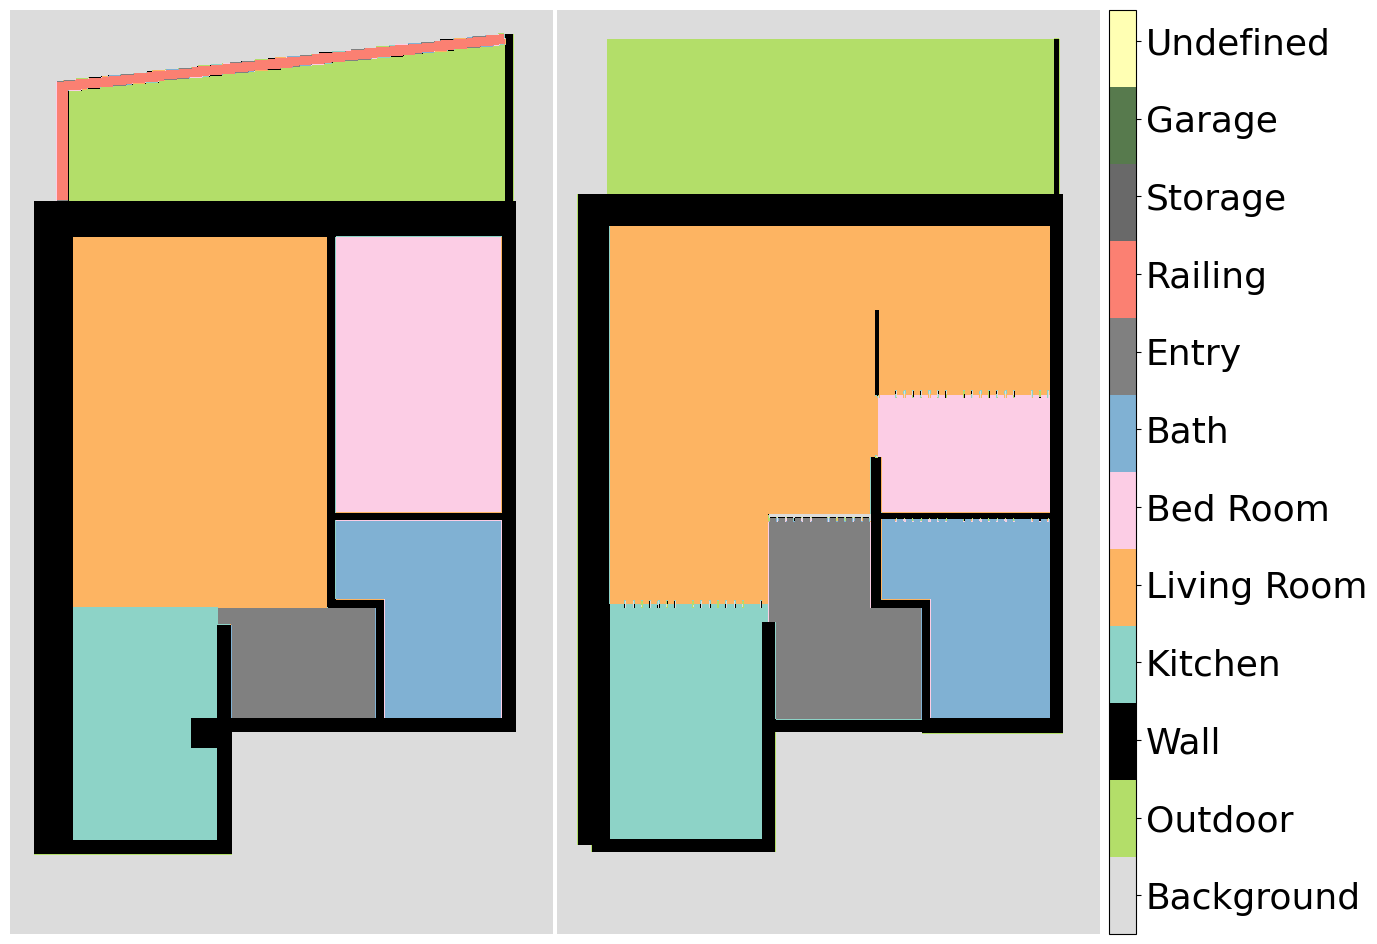

In [35]:
fig = plt.figure(figsize=(26, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
images = [label_np[0], pol_room_seg]
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(images[i], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = ax.cax.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5)
cbar.ax.set_yticklabels(room_classes, fontsize=26)
plt.show()

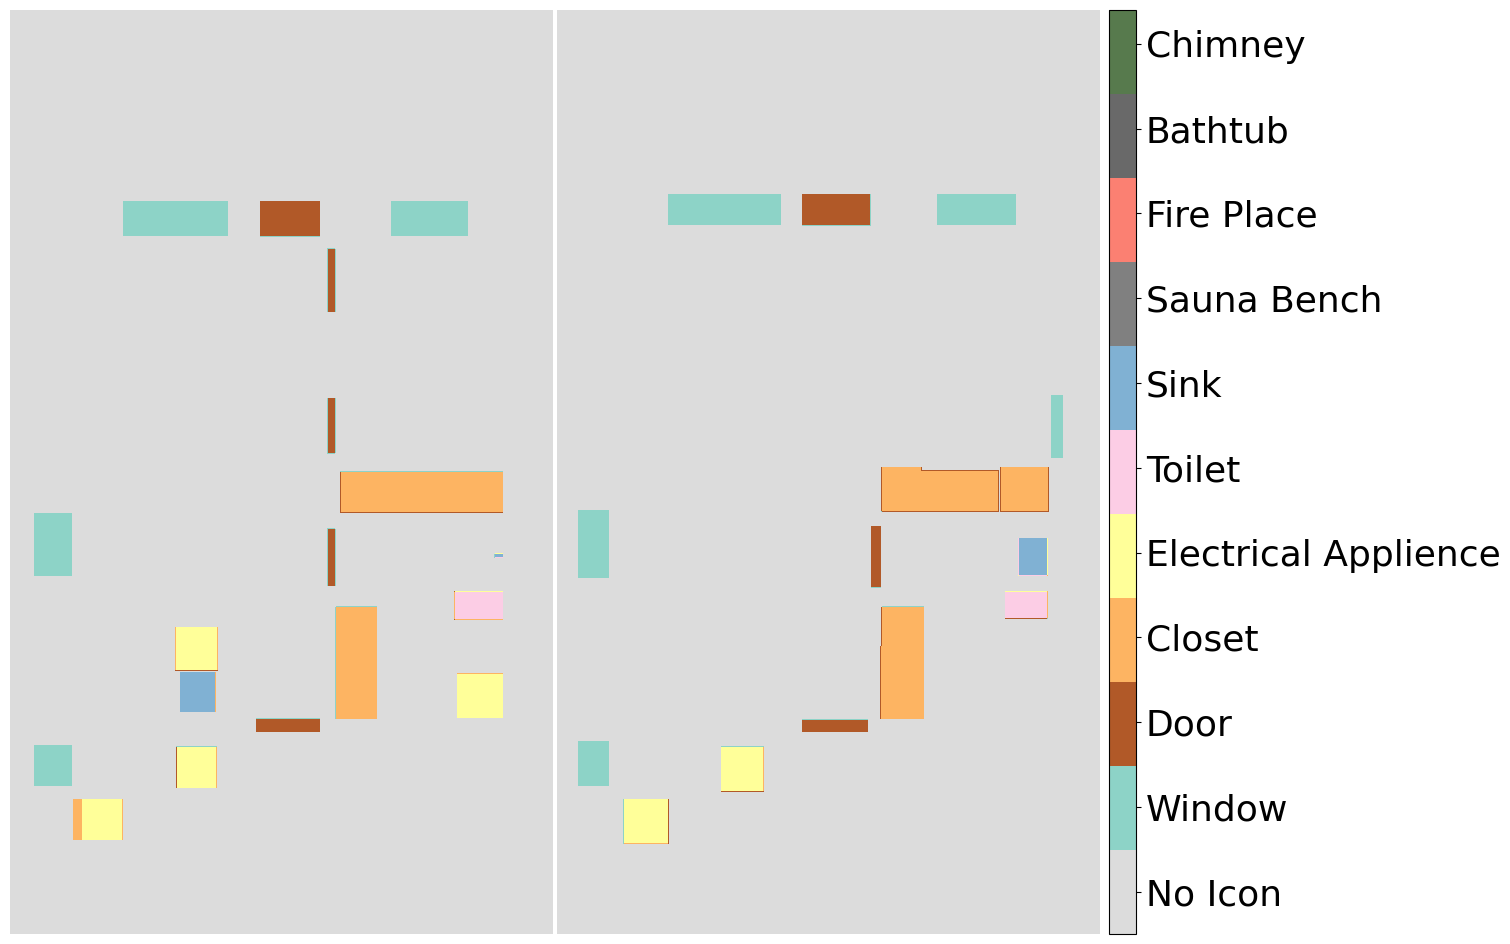

In [36]:
fig = plt.figure(figsize=(26, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

images = [label_np[1], pol_icon_seg]
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(images[i], cmap='icons', vmin=0, vmax=n_icons-0.1)

cbar = ax.cax.colorbar(iseg, ticks=np.arange(n_icons) + 0.5)
cbar.ax.set_yticklabels(icon_classes, fontsize=26)
plt.show()